# Student Name: Lucy Tan

# Preface

Consider the following Environment and Agent classes. 

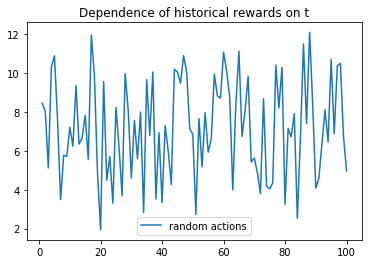

In [0]:
import random
from matplotlib import pyplot as plt 
import numpy as np

class Environment:
    def __init__(self):
        self.time = 1

    def admissible_actions(self):
        return list(range(1,5))

    def get_reward(self, action):
        self.time += 1
        q_star = 2*action+2
        return random.gauss(q_star,1)


class Agent:
    def __init__(self):
        self.current_reward = 0.0

    def step(self, env):
        actions = env.admissible_actions()
        reward = env.get_reward(random.choice(actions))
        self.current_reward = reward
        
        
def rewards_hist(T = 10):
    env = Environment()
    agent = Agent()
    rewards = []
    while env.time <= T:
        agent.step(env)
        rewards.append(agent.current_reward)
    return np.asarray(rewards)


from matplotlib import pyplot as plt 
import numpy as np
T = 100
plt.plot(range(1,T+1),rewards_hist(T),label='random actions')
plt.title('Dependence of historical rewards on t')
plt.legend()
plt.show()

## Problem 1 (15 points)

Notice that the agent currently selects actions randomly. Please implement the Gradient Bandit Algorithm with $\alpha$ = 0.4. Initialize the numerical preference at 0 for all actions. Run the algorithm 500 times (i.e. for 500 epochs) for T = 1000 and compute the observed average reward for each time t. Plot the average reward from those 500 epochs for 1, 2,..., T.

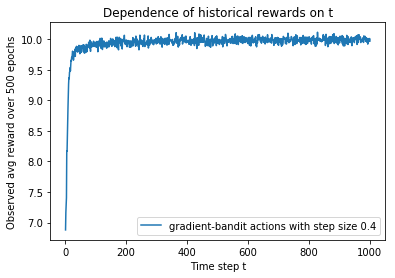

In [14]:
import random
from matplotlib import pyplot as plt 
import numpy as np
import math

class Environment:
    def __init__(self):
        self.time = 1

    def admissible_actions(self):
        return list(range(1,5))

    def get_reward(self, action):
        self.time += 1
        q_star = 2*action+2
        return random.gauss(q_star,1)


class Agent:
    def __init__(self, num_arms):
        self.current_reward = 0.0
        self.action_prefs = np.zeros(num_arms)
        self.action_probs = np.full(shape=(num_arms,), fill_value=1/num_arms, dtype=float)

    def step(self, env, step_size, rewards):
        actions = env.admissible_actions()
        chosen_action = self.choose_action(actions, step_size)
        reward = env.get_reward(chosen_action)
        self.current_reward = reward
        rewards.append(reward)
        rewards = np.asarray(rewards)
        avg_reward = np.mean(rewards)
        for action in actions:
            if action == chosen_action:
                self.action_prefs[action-1] = self.action_prefs[action-1] + step_size*(reward-avg_reward)*(1-self.action_probs[action-1])
            else:
                self.action_prefs[action-1] = self.action_prefs[action-1] - step_size*(reward-avg_reward)*self.action_probs[action-1]
        
    def choose_action(self, actions, step_size):
        sum_prefs = sum(math.exp(pref) for pref in self.action_prefs)
        for action in actions:
            self.action_probs[action-1] = math.exp(self.action_prefs[action-1]) / sum_prefs
        chosen_action = np.random.choice(actions, p = self.action_probs)
        return chosen_action
        
        
def rewards_hist(T = 10, step_size = 0.4):
    env = Environment()
    agent = Agent(len(env.admissible_actions()))
    rewards = []
    while env.time <= T:
        agent.step(env, step_size, rewards)
    return np.asarray(rewards)


from matplotlib import pyplot as plt 
epochs = 500
T = 1000
step_size = 0.4
all_rewards = []
for i in range(0, epochs):
    all_rewards.append(rewards_hist(T, step_size))

all_rewards = np.asarray(all_rewards)
avg_rewards = (np.mean(all_rewards, axis=0))

plt.plot(range(1,T+1), avg_rewards,label='gradient-bandit actions with step size 0.4')
plt.title('Dependence of historical rewards on t')
plt.ylabel('Observed avg reward over 500 epochs')
plt.xlabel('Time step t')
plt.legend()
plt.show()

## Problem 2 (10 points)

Add "state" attribute to the Environment which takes values 1 and 2. Assume that the agent still can take actions 1 through 4 in both states. If state=1, the agent gets rewards as in Problem 1, but in state 2 the Environment generates rewards with means -10, -8, -6, and -4 for actions 1, 2, 3, and 4, respectively (assume unit variance as before). Further, assume the Environment can change its state only if the agent selects action 1, and the probability of the switch is 0.05, that is:

$P(New State = 1|Old State = 2, action = 1)=0.05$,
$P(New State = 2|Old State = 2, action = 1)=0.95$,
$P(New State = 2|Old State = 1, action = 1)=0.05$,
$P(New State = 1|Old State = 1, action = 1)=0.95$.

All other transition probabilities are 0.      

Please modify the Gradient Bandit Algorithm you developed in Problem 1 so that numerical preference and policy is state-specific now, i.e. you need to keep track of observations in each state separately. Plot results and discuss your observations. Does the Gradient Bandit Algorithm appear to be appropriate in the case of Markov Decision Process (MDP)? Explain.


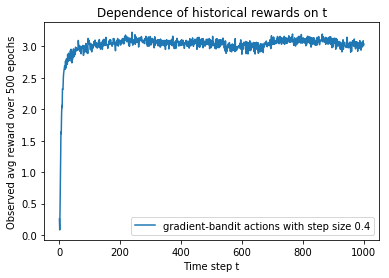

In [20]:
import random
from matplotlib import pyplot as plt 
import numpy as np
import math

class Environment:
    def __init__(self, initial_state):
        self.time = 1
        self.current_state = initial_state

    def admissible_actions(self):
        return list(range(1,5))
    
    def admissible_states(self):
        return list(range(1,3))

    def get_reward_and_new_state(self, action):
        self.time += 1
        state_reward_dict = {
            1:self.get_reward_state_1(action),
            2:self.get_reward_state_2(action)
        }
        # Associating the reward on the state that the action was chosen from, not the new state.
        reward = state_reward_dict.get(self.current_state)
        if action == 1:
            self.choose_state(self.admissible_states())
        return reward, self.current_state
    
    def get_reward_state_1(self, action):
        q_star = 2*action+2
        return random.gauss(q_star,1)
    
    def get_reward_state_2(self, action):
        action_reward_dict = {
            1:random.gauss(-10,1),
            2:random.gauss(-8,1),
            3:random.gauss(-6,1),
            4:random.gauss(-4,1)
        }
        return action_reward_dict.get(action)
    
    def choose_state(self, states):
        if self.current_state == states[0]:
            transition_probs = [0.95, 0.05]
        if self.current_state == states[1]:
            transition_probs = [0.05, 0.95]
        # Updating the environment's state
        self.current_state = np.random.choice(states, p=transition_probs)


class Agent:
    def __init__(self, initial_state, num_arms, num_states):
        self.current_reward = 0
        self.current_state = initial_state
        self.action_prefs = np.zeros(shape=(num_states, num_arms))
        self.action_probs = np.full(shape=(num_states, num_arms), fill_value=1/num_arms, dtype=float)

    def step(self, env, step_size, rewards_state_1, rewards_state_2):
        actions = env.admissible_actions()
        states = env.admissible_states()
        chosen_action = self.choose_action(actions, step_size)
        reward, new_state = env.get_reward_and_new_state(chosen_action)
        self.current_reward = reward
        
        if self.current_state == 1:
            rewards_state_1.append(reward)
            rewards_state_2.append(np.nan)
            avg_reward = np.nanmean(rewards_state_1)
        if self.current_state == 2:
            rewards_state_1.append(np.nan)
            rewards_state_2.append(reward)
            avg_reward = np.nanmean(rewards_state_2)
        
        for action in actions:
            if action == chosen_action:
                self.action_prefs[self.current_state-1][action-1] = self.action_prefs[self.current_state-1][action-1] + step_size*(reward-avg_reward)*(1-self.action_probs[self.current_state-1][action-1])
            else:
                self.action_prefs[self.current_state-1][action-1] = self.action_prefs[self.current_state-1][action-1] - step_size*(reward-avg_reward)*self.action_probs[self.current_state-1][action-1]

        # Updating the agent's state
        self.current_state = new_state
        
    def choose_action(self, actions, step_size):
        sum_prefs = sum(math.exp(pref) for pref in self.action_prefs[self.current_state-1])
        for action in actions:
            self.action_probs[self.current_state-1][action-1] = math.exp(self.action_prefs[self.current_state-1][action-1]) / sum_prefs
        chosen_action = np.random.choice(actions, p = self.action_probs[self.current_state-1])
        return chosen_action
        
        
def rewards_hist(T = 10, step_size = 0.4, initial_state = 1):
    env = Environment(initial_state)
    agent = Agent(initial_state, len(env.admissible_actions()), len(env.admissible_states()))
    rewards_state_1 = []
    rewards_state_2 = []
    while env.time <= T:
        agent.step(env, step_size, rewards_state_1, rewards_state_2)
    return np.asarray(rewards_state_1), np.asarray(rewards_state_2)


from matplotlib import pyplot as plt
epochs = 500
T = 1000
step_size = 0.4
all_rewards_state_1 = []
all_rewards_state_2 = []
for i in range(0, epochs):
    initial_state = random.choice([1,2])
    rewards_history = rewards_hist(T, step_size, initial_state)
    all_rewards_state_1.append(rewards_history[0])
    all_rewards_state_2.append(rewards_history[1])

all_rewards_state_1 = np.asarray(all_rewards_state_1)
all_rewards_state_2 = np.asarray(all_rewards_state_2)

all_rewards = np.concatenate([all_rewards_state_1, all_rewards_state_2])
avg_rewards = (np.nanmean(all_rewards, axis=0))

plt.plot(range(1,T+1), avg_rewards, label='gradient-bandit actions with step size 0.4')
plt.title('Dependence of historical rewards on t')
plt.ylabel('Observed avg reward over 500 epochs')
plt.xlabel('Time step t')
plt.legend()
plt.show()

The gradient bandit algorithm doesn't work well with Markov Decision Processes because in this case, the gradient bandit algorithm doesn't optimize the cumulative reward that the agent receives. The reward differs by state and the gradient bandit algorithm doesn't take into consideration how state transitions affect the reward. In this case, it learns to choose action 4 in both state 1 and 2 because action 4 results in the highest reward in each state (10 in state 2 and -4 in state 2). Averaging these two rewards results in 3, which is what the algorithm ultimately converges towards, as shown in the graph. This is a poorer performance than the case in problem 1 because the gradient bandit algorithm in problem 1 was able to optimize cumulative reward.